In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [55]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import polars as pl

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import lightgbm as lgb
import catboost as cb
import xgboost as xgb

import optuna
import pickle

import matplotlib.pyplot as plt
import numpy as np

import albumentations
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import cv2

import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import roc_curve, auc

In [3]:
# traindf= pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv')

In [4]:
# traindf['iddx_full']

# Will use idx full as target column

## Find category relation between target and idX_full

In [5]:
# # Group by 'target' and get unique values in 'iddx_full'
# unique_values = traindf.groupby('target')['iddx_full'].unique()

# # Convert the result to a dictionary for better readability
# unique_values_dict = unique_values.to_dict()

# print("Unique values of 'iddx_full' for each category in 'target':")
# print(unique_values_dict[1])

In [6]:
# print(unique_values_dict[0])

## Remove Not required columns

In [2]:
test_na_columns = [
    "lesion_id",
    "iddx_1",
    "iddx_2",
    "iddx_3",
    "iddx_4",
    "iddx_5",
    "mel_mitotic_index",
    "mel_thick_mm",
    "tbp_lv_dnn_lesion_confidence",
    "copyright_license",
    "attribution",
    "patient_id",
    "image_type"
]

In [8]:
# tdf  = traindf.drop(columns = test_na_columns)

In [9]:
# tdf.columns

## Look for column with missing values

In [10]:
# cols_with_nulls = traindf.columns[traindf.isnull().any()].tolist()

In [11]:
# traindf['sex'].unique()

# Numeric column with null values remove 

In [12]:
# tdf['tbp_lv_location_simple'].unique()

In [13]:
# tdf['anatom_site_general'].mode()

In [14]:
# tdf['age_approx'].median()

In [15]:
#  tdf['age_approx'].isnull().sum()

In [16]:
#  tdf['anatom_site_general'].isnull().sum()

In [17]:
#  tdf['sex'].isnull().sum()

# Read training Data

In [3]:
root = Path('/kaggle/input/isic-2024-challenge')

train_path = root / 'train-metadata.csv'
test_path = root / 'test-metadata.csv'
subm_path = root / 'sample_submission.csv'

id_col = 'isic_id'
target_col = 'iddx_full'
group_col = 'patient_id'

err = 1e-5
sampling_ratio = 0.01
seed = 42

num_cols = [
    'age_approx',                        # Approximate age of patient at time of imaging.
    'clin_size_long_diam_mm',            # Maximum diameter of the lesion (mm).+
    'tbp_lv_A',                          # A inside  lesion.+
    'tbp_lv_Aext',                       # A outside lesion.+
    'tbp_lv_B',                          # B inside  lesion.+
    'tbp_lv_Bext',                       # B outside lesion.+ 
    'tbp_lv_C',                          # Chroma inside  lesion.+
    'tbp_lv_Cext',                       # Chroma outside lesion.+
    'tbp_lv_H',                          # Hue inside the lesion; calculated as the angle of A* and B* in LAB* color space. Typical values range from 25 (red) to 75 (brown).+
    'tbp_lv_Hext',                       # Hue outside lesion.+
    'tbp_lv_L',                          # L inside lesion.+
    'tbp_lv_Lext',                       # L outside lesion.+
    'tbp_lv_areaMM2',                    # Area of lesion (mm^2).+
    'tbp_lv_area_perim_ratio',           # Border jaggedness, the ratio between lesions perimeter and area. Circular lesions will have low values; irregular shaped lesions will have higher values. Values range 0-10.+
    'tbp_lv_color_std_mean',             # Color irregularity, calculated as the variance of colors within the lesion's boundary.
    'tbp_lv_deltaA',                     # Average A contrast (inside vs. outside lesion).+
    'tbp_lv_deltaB',                     # Average B contrast (inside vs. outside lesion).+
    'tbp_lv_deltaL',                     # Average L contrast (inside vs. outside lesion).+
    'tbp_lv_deltaLB',                    #
    'tbp_lv_deltaLBnorm',                # Contrast between the lesion and its immediate surrounding skin. Low contrast lesions tend to be faintly visible such as freckles; high contrast lesions tend to be those with darker pigment. Calculated as the average delta LB of the lesion relative to its immediate background in LAB* color space. Typical values range from 5.5 to 25.+
    'tbp_lv_eccentricity',               # Eccentricity.+
    'tbp_lv_minorAxisMM',                # Smallest lesion diameter (mm).+
    'tbp_lv_nevi_confidence',            # Nevus confidence score (0-100 scale) is a convolutional neural network classifier estimated probability that the lesion is a nevus. The neural network was trained on approximately 57,000 lesions that were classified and labeled by a dermatologist.+,++
    'tbp_lv_norm_border',                # Border irregularity (0-10 scale); the normalized average of border jaggedness and asymmetry.+
    'tbp_lv_norm_color',                 # Color variation (0-10 scale); the normalized average of color asymmetry and color irregularity.+
    'tbp_lv_perimeterMM',                # Perimeter of lesion (mm).+
    'tbp_lv_radial_color_std_max',       # Color asymmetry, a measure of asymmetry of the spatial distribution of color within the lesion. This score is calculated by looking at the average standard deviation in LAB* color space within concentric rings originating from the lesion center. Values range 0-10.+
    'tbp_lv_stdL',                       # Standard deviation of L inside  lesion.+
    'tbp_lv_stdLExt',                    # Standard deviation of L outside lesion.+
    'tbp_lv_symm_2axis',                 # Border asymmetry; a measure of asymmetry of the lesion's contour about an axis perpendicular to the lesion's most symmetric axis. Lesions with two axes of symmetry will therefore have low scores (more symmetric), while lesions with only one or zero axes of symmetry will have higher scores (less symmetric). This score is calculated by comparing opposite halves of the lesion contour over many degrees of rotation. The angle where the halves are most similar identifies the principal axis of symmetry, while the second axis of symmetry is perpendicular to the principal axis. Border asymmetry is reported as the asymmetry value about this second axis. Values range 0-10.+
    'tbp_lv_symm_2axis_angle',           # Lesion border asymmetry angle.+
    'tbp_lv_x',                          # X-coordinate of the lesion on 3D TBP.+
    'tbp_lv_y',                          # Y-coordinate of the lesion on 3D TBP.+
    'tbp_lv_z',                          # Z-coordinate of the lesion on 3D TBP.+
]

new_num_cols = [
    'lesion_size_ratio',             # tbp_lv_minorAxisMM      / clin_size_long_diam_mm
    'lesion_shape_index',            # tbp_lv_areaMM2          / tbp_lv_perimeterMM **2
    'hue_contrast',                  # tbp_lv_H                - tbp_lv_Hext              abs
    'luminance_contrast',            # tbp_lv_L                - tbp_lv_Lext              abs
    'lesion_color_difference',       # tbp_lv_deltaA **2       + tbp_lv_deltaB **2 + tbp_lv_deltaL **2  sqrt  
    'border_complexity',             # tbp_lv_norm_border      + tbp_lv_symm_2axis
    'color_uniformity',              # tbp_lv_color_std_mean   / tbp_lv_radial_color_std_max

    'position_distance_3d',          # tbp_lv_x **2 + tbp_lv_y **2 + tbp_lv_z **2  sqrt
    'perimeter_to_area_ratio',       # tbp_lv_perimeterMM      / tbp_lv_areaMM2
    'area_to_perimeter_ratio',       # tbp_lv_areaMM2          / tbp_lv_perimeterMM
    'lesion_visibility_score',       # tbp_lv_deltaLBnorm      + tbp_lv_norm_color
    'symmetry_border_consistency',   # tbp_lv_symm_2axis       * tbp_lv_norm_border
    'consistency_symmetry_border',   # tbp_lv_symm_2axis       * tbp_lv_norm_border / (tbp_lv_symm_2axis + tbp_lv_norm_border)

    'color_consistency',             # tbp_lv_stdL             / tbp_lv_Lext
    'consistency_color',             # tbp_lv_stdL*tbp_lv_Lext / tbp_lv_stdL + tbp_lv_Lext
    'size_age_interaction',          # clin_size_long_diam_mm  * age_approx
    'hue_color_std_interaction',     # tbp_lv_H                * tbp_lv_color_std_mean
    'lesion_severity_index',         # tbp_lv_norm_border      + tbp_lv_norm_color + tbp_lv_eccentricity / 3
    'shape_complexity_index',        # border_complexity       + lesion_shape_index
    'color_contrast_index',          # tbp_lv_deltaA + tbp_lv_deltaB + tbp_lv_deltaL + tbp_lv_deltaLBnorm

    'log_lesion_area',               # tbp_lv_areaMM2          + 1  np.log
    'normalized_lesion_size',        # clin_size_long_diam_mm  / age_approx
    'mean_hue_difference',           # tbp_lv_H                + tbp_lv_Hext    / 2
    'std_dev_contrast',              # tbp_lv_deltaA **2 + tbp_lv_deltaB **2 + tbp_lv_deltaL **2   / 3  np.sqrt
    'color_shape_composite_index',   # tbp_lv_color_std_mean   + bp_lv_area_perim_ratio + tbp_lv_symm_2axis   / 3
    'lesion_orientation_3d',         # tbp_lv_y                , tbp_lv_x  np.arctan2
    'overall_color_difference',      # tbp_lv_deltaA           + tbp_lv_deltaB + tbp_lv_deltaL   / 3

    'symmetry_perimeter_interaction',# tbp_lv_symm_2axis       * tbp_lv_perimeterMM
    'comprehensive_lesion_index',    # tbp_lv_area_perim_ratio + tbp_lv_eccentricity + bp_lv_norm_color + tbp_lv_symm_2axis   / 4
    'color_variance_ratio',          # tbp_lv_color_std_mean   / tbp_lv_stdLExt
    'border_color_interaction',      # tbp_lv_norm_border      * tbp_lv_norm_color
    'border_color_interaction_2',
    'size_color_contrast_ratio',     # clin_size_long_diam_mm  / tbp_lv_deltaLBnorm
    'age_normalized_nevi_confidence',# tbp_lv_nevi_confidence  / age_approx
    'age_normalized_nevi_confidence_2',
    'color_asymmetry_index',         # tbp_lv_symm_2axis       * tbp_lv_radial_color_std_max

    'volume_approximation_3d',       # tbp_lv_areaMM2          * sqrt(tbp_lv_x**2 + tbp_lv_y**2 + tbp_lv_z**2)
    'color_range',                   # abs(tbp_lv_L - tbp_lv_Lext) + abs(tbp_lv_A - tbp_lv_Aext) + abs(tbp_lv_B - tbp_lv_Bext)
    'shape_color_consistency',       # tbp_lv_eccentricity     * tbp_lv_color_std_mean
    'border_length_ratio',           # tbp_lv_perimeterMM      / pi * sqrt(tbp_lv_areaMM2 / pi)
    'age_size_symmetry_index',       # age_approx              * clin_size_long_diam_mm * tbp_lv_symm_2axis
    'index_age_size_symmetry',       # age_approx              * tbp_lv_areaMM2 * tbp_lv_symm_2axis
]

cat_cols = ['sex', 'anatom_site_general', 'tbp_tile_type', 'tbp_lv_location', 'tbp_lv_location_simple']
feature_cols = num_cols + new_num_cols + cat_cols 

In [4]:
len(new_num_cols)

42

In [5]:
def read_data(path):
    return (
        pl.DataFrame(path)
        .with_columns(
            lesion_size_ratio              = pl.col('tbp_lv_minorAxisMM') / pl.col('clin_size_long_diam_mm'),
            lesion_shape_index             = pl.col('tbp_lv_areaMM2') / (pl.col('tbp_lv_perimeterMM') ** 2),
            hue_contrast                   = (pl.col('tbp_lv_H') - pl.col('tbp_lv_Hext')).abs(),
            luminance_contrast             = (pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')).abs(),
            lesion_color_difference        = (pl.col('tbp_lv_deltaA') ** 2 + pl.col('tbp_lv_deltaB') ** 2 + pl.col('tbp_lv_deltaL') ** 2).sqrt(),
            border_complexity              = pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_symm_2axis'),
            color_uniformity               = pl.col('tbp_lv_color_std_mean') / (pl.col('tbp_lv_radial_color_std_max') + err),
        )
        .with_columns(
            position_distance_3d           = (pl.col('tbp_lv_x') ** 2 + pl.col('tbp_lv_y') ** 2 + pl.col('tbp_lv_z') ** 2).sqrt(),
            perimeter_to_area_ratio        = pl.col('tbp_lv_perimeterMM') / pl.col('tbp_lv_areaMM2'),
            area_to_perimeter_ratio        = pl.col('tbp_lv_areaMM2') / pl.col('tbp_lv_perimeterMM'),
            lesion_visibility_score        = pl.col('tbp_lv_deltaLBnorm') + pl.col('tbp_lv_norm_color'),
            symmetry_border_consistency    = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_norm_border'),
            consistency_symmetry_border    = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_norm_border') / (pl.col('tbp_lv_symm_2axis') + pl.col('tbp_lv_norm_border')),
        )
        .with_columns(
            color_consistency              = pl.col('tbp_lv_stdL') / pl.col('tbp_lv_Lext'),
            consistency_color              = pl.col('tbp_lv_stdL') * pl.col('tbp_lv_Lext') / (pl.col('tbp_lv_stdL') + pl.col('tbp_lv_Lext')),
            size_age_interaction           = pl.col('clin_size_long_diam_mm') * pl.col('age_approx'),
            hue_color_std_interaction      = pl.col('tbp_lv_H') * pl.col('tbp_lv_color_std_mean'),
            lesion_severity_index          = (pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_norm_color') + pl.col('tbp_lv_eccentricity')) / 3,
            shape_complexity_index         = pl.col('border_complexity') + pl.col('lesion_shape_index'),
            color_contrast_index           = pl.col('tbp_lv_deltaA') + pl.col('tbp_lv_deltaB') + pl.col('tbp_lv_deltaL') + pl.col('tbp_lv_deltaLBnorm'),
        )
        .with_columns(
            log_lesion_area                = (pl.col('tbp_lv_areaMM2') + 1).log(),
            normalized_lesion_size         = pl.col('clin_size_long_diam_mm') / pl.col('age_approx'),
            mean_hue_difference            = (pl.col('tbp_lv_H') + pl.col('tbp_lv_Hext')) / 2,
            std_dev_contrast               = ((pl.col('tbp_lv_deltaA') ** 2 + pl.col('tbp_lv_deltaB') ** 2 + pl.col('tbp_lv_deltaL') ** 2) / 3).sqrt(),
            color_shape_composite_index    = (pl.col('tbp_lv_color_std_mean') + pl.col('tbp_lv_area_perim_ratio') + pl.col('tbp_lv_symm_2axis')) / 3,
            lesion_orientation_3d          = pl.arctan2(pl.col('tbp_lv_y'), pl.col('tbp_lv_x')),
            overall_color_difference       = (pl.col('tbp_lv_deltaA') + pl.col('tbp_lv_deltaB') + pl.col('tbp_lv_deltaL')) / 3,
        )
        .with_columns(
            symmetry_perimeter_interaction = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_perimeterMM'),
            comprehensive_lesion_index     = (pl.col('tbp_lv_area_perim_ratio') + pl.col('tbp_lv_eccentricity') + pl.col('tbp_lv_norm_color') + pl.col('tbp_lv_symm_2axis')) / 4,
            color_variance_ratio           = pl.col('tbp_lv_color_std_mean') / pl.col('tbp_lv_stdLExt'),
            border_color_interaction       = pl.col('tbp_lv_norm_border') * pl.col('tbp_lv_norm_color'),
            border_color_interaction_2     = pl.col('tbp_lv_norm_border') * pl.col('tbp_lv_norm_color') / (pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_norm_color')),
            size_color_contrast_ratio      = pl.col('clin_size_long_diam_mm') / pl.col('tbp_lv_deltaLBnorm'),
            age_normalized_nevi_confidence = pl.col('tbp_lv_nevi_confidence') / pl.col('age_approx'),
            age_normalized_nevi_confidence_2 = (pl.col('clin_size_long_diam_mm')**2 + pl.col('age_approx')**2).sqrt(),
            color_asymmetry_index          = pl.col('tbp_lv_radial_color_std_max') * pl.col('tbp_lv_symm_2axis'),
        )
        .with_columns(
            volume_approximation_3d        = pl.col('tbp_lv_areaMM2') * (pl.col('tbp_lv_x')**2 + pl.col('tbp_lv_y')**2 + pl.col('tbp_lv_z')**2).sqrt(),
            color_range                    = (pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')).abs() + (pl.col('tbp_lv_A') - pl.col('tbp_lv_Aext')).abs() + (pl.col('tbp_lv_B') - pl.col('tbp_lv_Bext')).abs(),
            shape_color_consistency        = pl.col('tbp_lv_eccentricity') * pl.col('tbp_lv_color_std_mean'),
            border_length_ratio            = pl.col('tbp_lv_perimeterMM') / (2 * np.pi * (pl.col('tbp_lv_areaMM2') / np.pi).sqrt()),
            age_size_symmetry_index        = pl.col('age_approx') * pl.col('clin_size_long_diam_mm') * pl.col('tbp_lv_symm_2axis'),
            index_age_size_symmetry        = pl.col('age_approx') * pl.col('tbp_lv_areaMM2') * pl.col('tbp_lv_symm_2axis'),
        )
        .to_pandas()
    )

In [6]:
def preprocess(df_train,is_test = False):

    global cat_cols

    df_train.drop(columns = test_na_columns,inplace=True)

    # Select numerical columns
    numerical_cols = df_train.select_dtypes(include=['number']).columns.tolist()
    
    # Initialize the scaler
    scaler = StandardScaler()
    numerical_cols.remove('target')
    # Fit the scaler on the numerical data and transform
    df_train[numerical_cols] = scaler.fit_transform(df_train[numerical_cols])

    # Save the scaler object
    with open('scaler.pkl', 'wb') as file:
        pickle.dump(scaler, file)

    encoder = OneHotEncoder(sparse_output=False)
    encoder.fit(df_train[cat_cols])

    MAX_CAT_VAR_NAME_SIZE = 30
    new_cat_cols = [x.replace(" ", "_")[:MAX_CAT_VAR_NAME_SIZE] for x in encoder.get_feature_names_out()]

    df_train[new_cat_cols] = encoder.transform(df_train[cat_cols])
        
    for col in cat_cols:
        feature_cols.remove(col)

    df_train.drop(columns = cat_cols,inplace=True)

    feature_cols.extend(new_cat_cols)
    cat_cols = new_cat_cols

    if is_test == False:
        enc = OrdinalEncoder()
        enc.fit(df_train[[target_col]])
        df_train[target_col] = enc.transform(df_train[[target_col]])
        with open('ordinalEndoder.pkl', 'wb') as file:
            pickle.dump(enc, file)

    return df_train

In [7]:
df_train = pd.read_csv(train_path)

mode_values = df_train.select_dtypes(include=['object']).mode().iloc[0]
df_train.fillna(mode_values, inplace=True)

median_values = df_train.select_dtypes(include=['number']).median()

# Fill null values with the median values
df_train.fillna(median_values, inplace=True)

/tmp/ipykernel_33/3777118591.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(train_path)


In [8]:
df_train = read_data(df_train)


In [9]:
df_train = preprocess(df_train)

/tmp/ipykernel_33/3971734547.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[new_cat_cols] = encoder.transform(df_train[cat_cols])
/tmp/ipykernel_33/3971734547.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[new_cat_cols] = encoder.transform(df_train[cat_cols])
/tmp/ipykernel_33/3971734547.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) 

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Columns: 117 entries, isic_id to tbp_lv_location_simple_Unknown
dtypes: float64(115), int64(1), object(1)
memory usage: 358.0+ MB


In [11]:
df_train.columns[df_train.isnull().any()].tolist()

[]

In [12]:
print(df_train.columns.to_list())

['isic_id', 'target', 'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color', 'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'iddx_full', 'lesion_size_ratio', 'lesion_shape_index', 'hue_contrast', 'luminance_contrast', 'lesion_color_difference', 'border_complexity', 'color_uniformity', 'position_distance_3d', 'perimeter_to_area_ratio', 'area_to_perimeter_ratio', 'lesion_visibility_score', 'symmetry_border_consistency', 'consistency_symmetry_border', 'color_consistency', 'consist

In [17]:
pd.set_option('display.max_rows', 60)

In [18]:
print(len(df_train.columns.to_list()))

117


In [19]:
df_train['index_age_size_symmetry'].unique()

array([-0.17569906, -0.6720504 , -0.38675653, ..., -0.07025351,
       -0.58374151, -0.60227648])

In [20]:
df_train.iloc[10070].iddx_full

0.0

In [ ]:
df_train.to_csv('/kaggle/working/preprocessDataset.csv',index=False)

In [ ]:
# df_train = pd.read_csv(train_path)

# Removing the Psychic from dataset

In [107]:
# pdf = pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv')

/tmp/ipykernel_33/3838486438.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  pdf = pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv')


In [106]:
# df_selfclean = pd.read_csv('/kaggle/input/isic-2024-challenge-selfclean-scores/ISIC_2024_Challenge_SelfClean_Scores.csv')
# df_selfclean.drop(columns=['irrelevant_ranking', 'label_error_ranking'], inplace=True)
# df_selfclean.head()

,img_name,isic_id,patient_id,irrelevant_score,label_error_score
0,ISIC_6550315,ISIC_6550315,IP_6547234,0.997475,0.855348
1,ISIC_2142098,ISIC_2142098,IP_2480242,0.997926,0.968779
2,ISIC_6724877,ISIC_6724877,IP_1117889,0.998249,0.982267
3,ISIC_7001093,ISIC_7001093,IP_5102122,0.997783,0.945050
4,ISIC_8188116,ISIC_8188116,IP_3921915,0.998260,0.978268


In [108]:
# pdf = pdf.merge(df_selfclean, on=["isic_id", "patient_id"])
# pdf.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,img_name,irrelevant_score,label_error_score
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,NaN,NaN,NaN,NaN,NaN,97.517282,ISIC_0015670,0.998226,0.932858
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,NaN,NaN,NaN,NaN,NaN,NaN,3.141455,ISIC_0015845,0.996162,0.749375
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,NaN,NaN,NaN,NaN,NaN,99.804040,ISIC_0015864,0.998182,0.975466
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,NaN,NaN,NaN,NaN,NaN,99.989998,ISIC_0015902,0.998253,0.994378
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,NaN,NaN,NaN,NaN,NaN,70.442510,ISIC_0024200,0.997726,0.895673


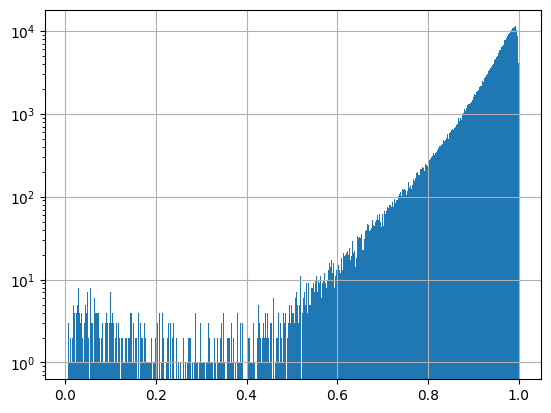

In [111]:
# pdf["label_error_score"].hist(bins="sqrt")
# plt.yscale("log")
# plt.show()

# Remove Hair

In [80]:
path_list = [f"/kaggle/input/isic-2024-challenge/train-image/image/{id}.jpg" for id in df_train.isic_id]

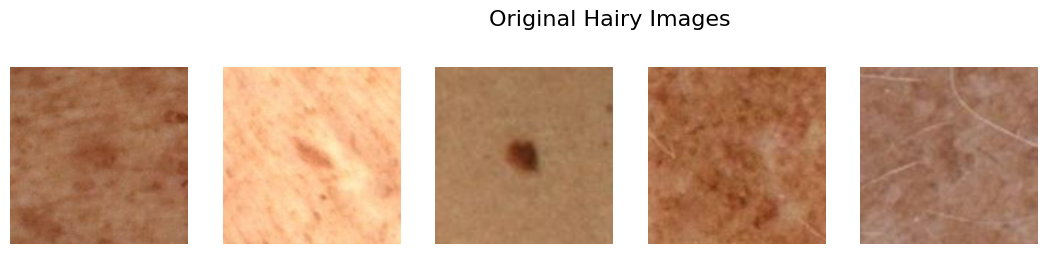

In [103]:
import matplotlib.image as mpimg

image_hair = np.array(path_list)[[1202, 216, 8854, 1174, 131, 174]]

def hair_remove(image):
    # convert image to grayScale
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # kernel for morphologyEx
    kernel = cv2.getStructuringElement(1,(17,17))

    # apply MORPH_BLACKHAT to grayScale image
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)

    # apply thresholding to blackhat
    _,threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)

    # inpaint with original image and threshold image
    final_image = cv2.inpaint(image,threshold,1,cv2.INPAINT_TELEA)

    return final_image

# Show the Augmented Images
plt.figure(figsize=(16,3))
plt.suptitle("Original Hairy Images", fontsize = 16)
    
for k, path in enumerate(image_hair[:5]):
    image = mpimg.imread(path)
    image = cv2.resize(image,(300, 300))
        
    plt.subplot(1, 6, k+1)
    plt.imshow(image)
    plt.axis('off')

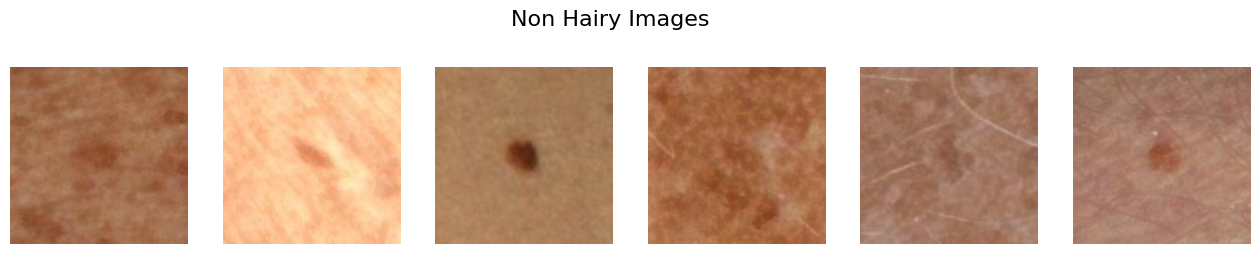

In [104]:
# Show the sample
plt.figure(figsize=(16,3))
plt.suptitle("Non Hairy Images", fontsize = 16)
    
for k, path in enumerate(image_hair):
    image = mpimg.imread(path)
    image = cv2.resize(image,(300, 300))
    image = hair_remove(image)
        
    plt.subplot(1, 6, k+1)
    plt.imshow(image)
    plt.axis('off')

# prepare dataset for iamges

In [116]:
class MelanomaDataset(Dataset):
    def __init__(self, csv, mode, meta_features, transform=None):

        self.csv = csv.reset_index(drop=True)
        self.mode = mode
        self.use_meta = meta_features is not None
        self.meta_features = meta_features
        self.transform = transform

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, index):

        row = self.csv.iloc[index]
        #print(row)
        train_image_base_path  = f'/kaggle/input/isic-2024-challenge/train-image/image/{row.isic_id}.jpg'
        #print("filePath:"+train_image_base_path)
        image = cv2.imread(train_image_base_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = hair_remove(image)
        if self.transform is not None:
            res = self.transform(image=image)
            image = res['image'].astype(np.float32)
        else:
            image = image.astype(np.float32)

        image = image.transpose(2, 0, 1)
        #print(self.csv.iloc[index][self.meta_features])
        if self.use_meta:
            data = (torch.tensor(image).float(), torch.tensor(self.csv.iloc[index][self.meta_features]).float())
        else:
            data = torch.tensor(image).float()

        if self.mode == 'test':
            return data
        else:
            return data, torch.tensor(self.csv.iloc[index].iddx_full).float()

In [ ]:
# # Incluir la transformación personalizada en el pipeline
# transform = transforms.Compose([
#     transforms.Resize(299),
#     transforms.CenterCrop(299),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# transform_test = transforms.Compose([
#     transforms.Resize(299),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])


In [84]:
def get_transforms(image_size):

    transforms_train = albumentations.Compose([
        albumentations.Transpose(p=0.5),
        albumentations.VerticalFlip(p=0.5),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2,p=0.75),
        albumentations.OneOf([
            albumentations.MotionBlur(blur_limit=5),
            albumentations.MedianBlur(blur_limit=5),
            albumentations.GaussianBlur(blur_limit=5),
            albumentations.GaussNoise(var_limit=(5.0, 30.0)),
        ], p=0.7),

        albumentations.OneOf([
            albumentations.OpticalDistortion(distort_limit=1.0),
            albumentations.GridDistortion(num_steps=5, distort_limit=1.),
            albumentations.ElasticTransform(alpha=3),
        ], p=0.7),

        albumentations.CLAHE(clip_limit=4.0, p=0.7),
        #albumentations.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
        albumentations.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
        albumentations.Resize(image_size, image_size),
        albumentations.CoarseDropout(max_holes= 3,max_height = int(image_size * 0.20),min_holes = 1,max_width =int(image_size * 0.20),p=0.7 ),
        albumentations.Normalize()
    ])

    transforms_val = albumentations.Compose([
        albumentations.Resize(image_size, image_size),
        albumentations.Normalize()
    ])

    return transforms_train, transforms_val

# Split and Prepare Dataset

In [ ]:
# albumentations.Cutout(max_h_size=int(image_size * 0.375), max_w_size=int(image_size * 0.375), num_holes=1, p=0.7),

In [ ]:
# albumentations.Compose([albumentations.Transpose(p=0.5),albumentations.CoarseDropout(max_holes= 3,max_height = int(image_size * 0.375),min_holes = 0,max_width =int(image_size * 0.375),p=0.7 )])

In [24]:
EfficientNetB0 = 224
EfficientNetB1 = 240
EfficientNetB2 = 260

In [25]:
trans_train, trans_test =  get_transforms(EfficientNetB0)

/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/blur/transforms.py:180: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


## Train and Test Features

In [26]:
dataset_features = df_train.columns.to_list()
training_features = list(set(dataset_features)-set(['target','isic_id']))
test_val_features = list(set(dataset_features)-set(['target','iddx_full','isic_id']))


In [27]:
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import LabelEncoder


Train, Valid = tts(df_train, test_size = 0.03, stratify = df_train['target'],random_state=42)

print(f"Train Shape is: {Train.shape}")
print(f"Valid Shape is: {Valid.shape}")

print(f"Validation and Test Len is {(Valid.shape[0] ) / df_train.shape[0] :.2%}")



Train Shape is: (389027, 117)
Valid Shape is: (12032, 117)
Validation and Test Len is 3.00%


In [117]:
train_ds = MelanomaDataset(Train,'train',training_features ,transform = trans_train)
valid_ds = MelanomaDataset(Valid,'valid',test_val_features,transform = trans_test)

train_dl = DataLoader(train_ds, batch_size = 32, shuffle = True)
valid_dl = DataLoader(valid_ds, batch_size = 32, shuffle = False)



In [118]:
iterator = iter(train_dl)

In [119]:
(images,features),targets = next(iterator)

/tmp/ipykernel_33/3545381215.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data = (torch.tensor(image).float(), torch.tensor(self.csv.iloc[index][self.meta_features]).float())
/tmp/ipykernel_33/3545381215.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data = (torch.tensor(image).float(), torch.tensor(self.csv.iloc[index][self.meta_features]).float())
/tmp/ipykernel_33/3545381215.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.i

In [88]:
features.shape

torch.Size([32, 115])

In [66]:
images.shape

torch.Size([32, 3, 224, 224])

In [100]:
images = images.numpy()


In [90]:
def show_batch(image_batch, label_batch,cols=5):
    plt.figure(figsize=(20,20))
    num_images = image_batch.shape[0]
    num_rows = int(np.ceil(num_images / cols))
    for n in range(len(image_batch)):
        ax = plt.subplot(num_rows,cols,n+1)
        plt.imshow(image_batch[n].transpose(1, 2, 0))
        plt.title(label_batch[n])
        plt.axis('off')

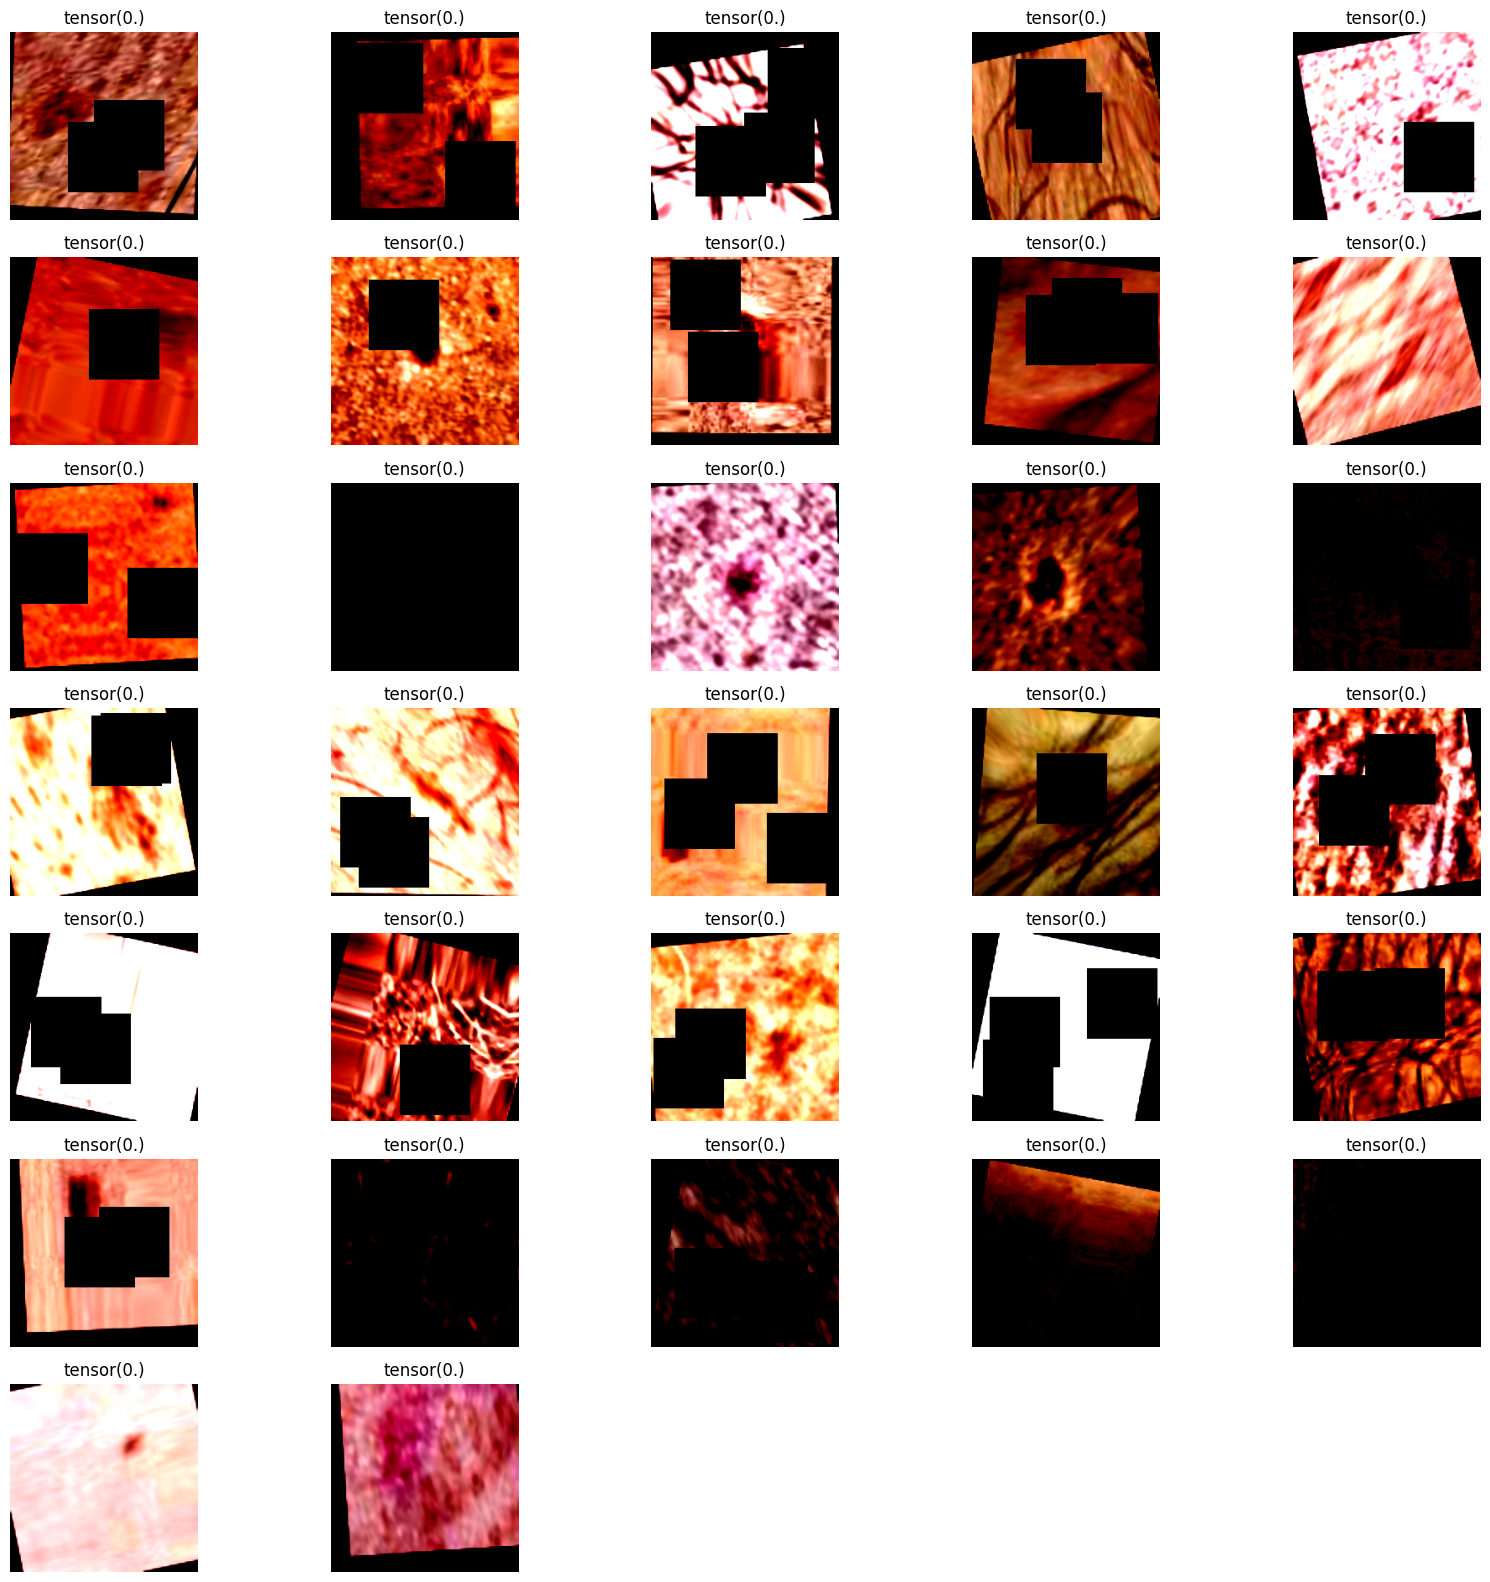

In [101]:
show_batch(images,targets,cols=5)

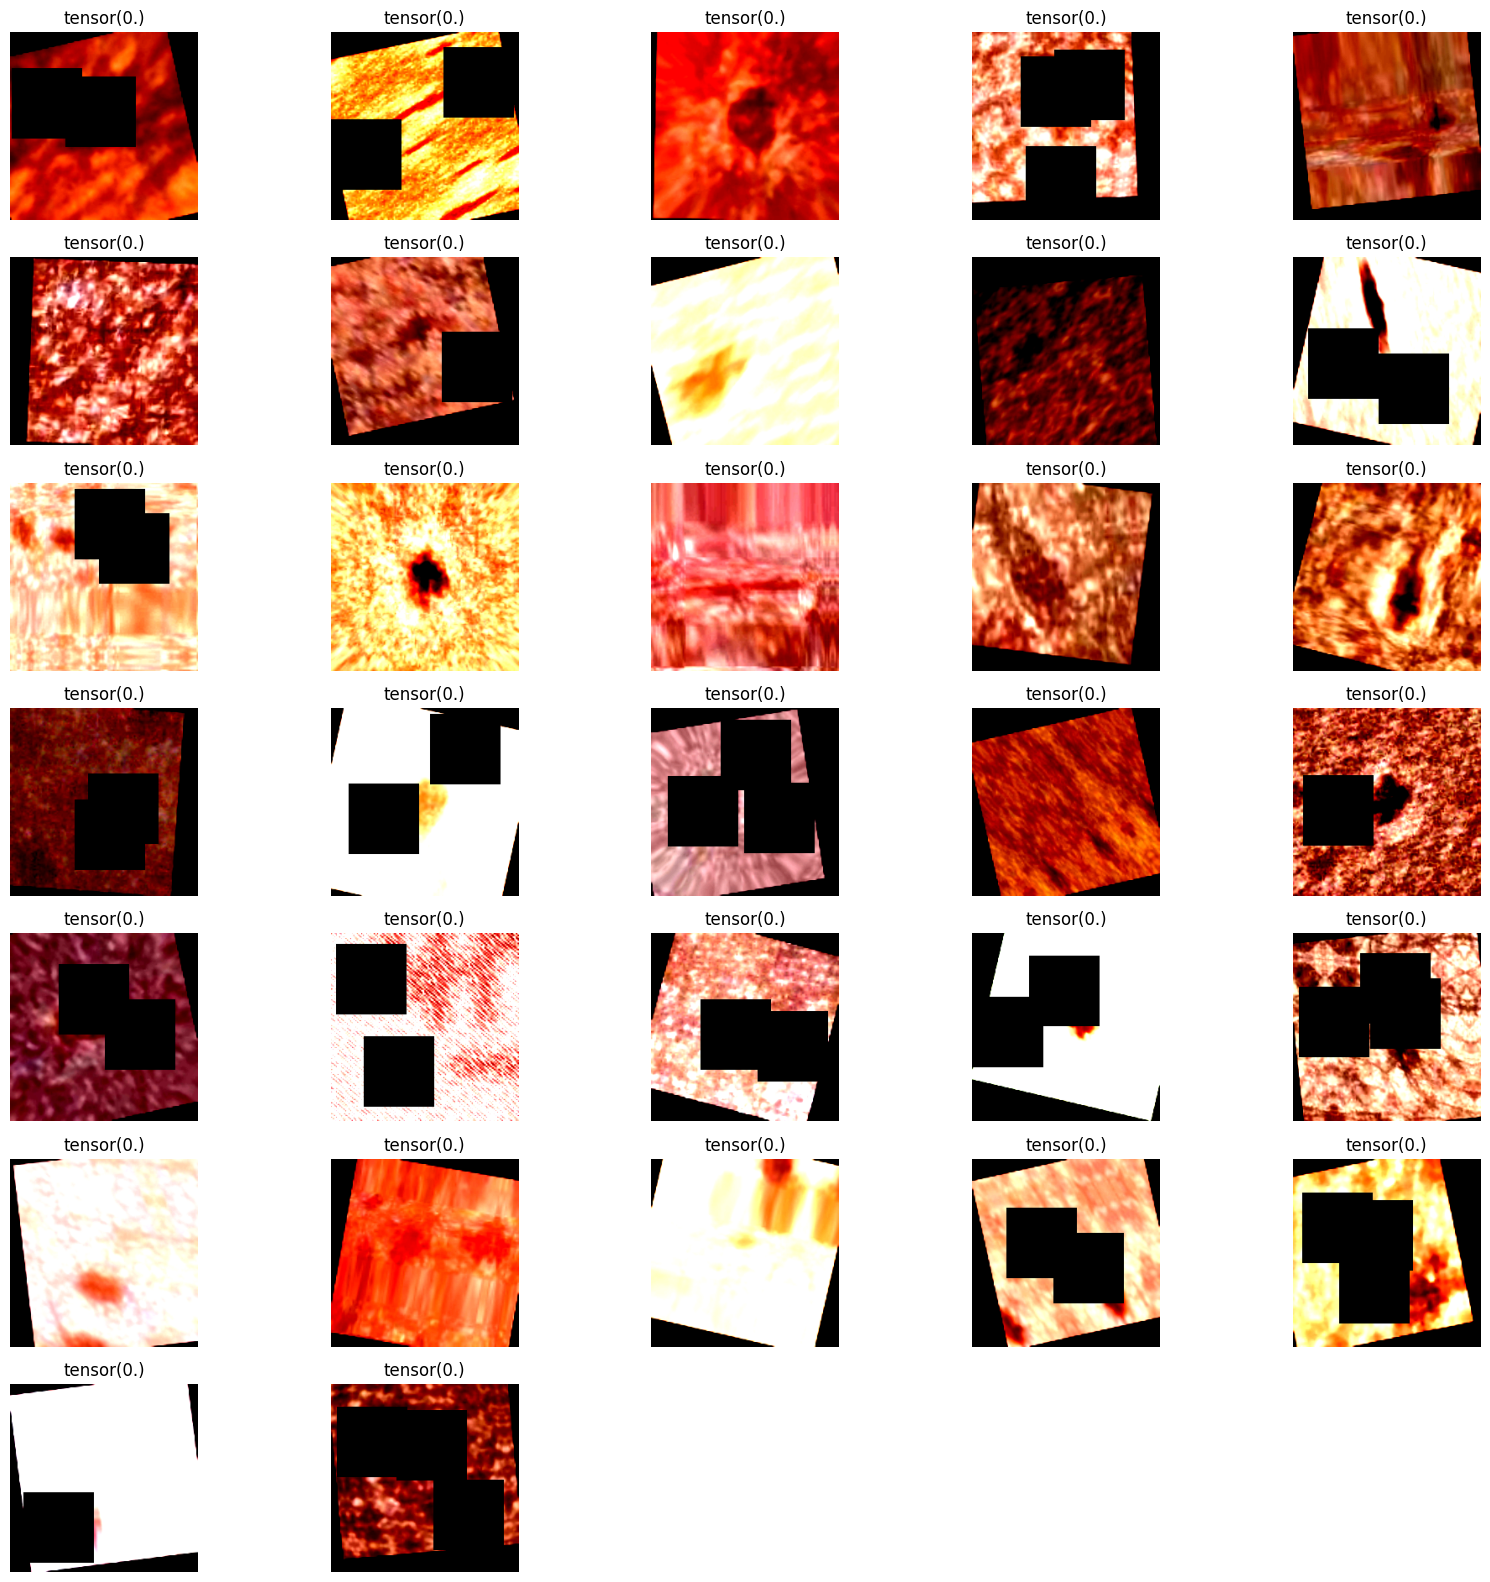

In [94]:
show_batch(images,targets,cols=5)

# Prepare a Model

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
# Set seed
seed_everything(SEED)

In [7]:
from timm import create_model
from timm import list_models
import timm

# Find list of available models

In [10]:
#all_timm_models = timm.list_models('efficientnet*')

In [32]:

sigmoid = nn.Sigmoid()


class Swish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * sigmoid(i)
        ctx.save_for_backward(i)
        return result
    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))


class Swish_Module(nn.Module):
    def forward(self, x):
        return Swish.apply(x)

In [43]:
class Effnet_Melanoma(nn.Module):
    def __init__(self, enet_type, out_dim, n_meta_features=0, n_meta_dim=[512, 128], pretrained=False,num_heads=2):
        super(Effnet_Melanoma, self).__init__()
        self.n_meta_features = n_meta_features
        self.effnet = timm.create_model(enet_type, pretrained=True)
        self.dropouts = nn.ModuleList([
            nn.Dropout(0.5) for _ in range(5)
        ])
        in_ch = self.effnet.classifier.in_features
        
        if n_meta_features > 0:
            self.meta = nn.Sequential(
                nn.Linear(n_meta_features, n_meta_dim[0]),
                nn.BatchNorm1d(n_meta_dim[0]),
                Swish_Module(),
                nn.Dropout(p=0.3),
                nn.Linear(n_meta_dim[0], n_meta_dim[1]),
                nn.BatchNorm1d(n_meta_dim[1]),
                Swish_Module(),
            )
            
            self.reduce_dim = nn.Linear(in_ch, n_meta_dim[1])
            self.cross_attention = nn.MultiheadAttention(embed_dim=n_meta_dim[1], num_heads=num_heads)
            
            in_ch = n_meta_dim[1]
        self.myfc = nn.Linear(in_ch, out_dim)
        self.effnet.classifier = nn.Identity()

    def extract(self, x):
        x = self.effnet(x)
        return x

    def forward(self, x, x_meta=None):
        x = self.extract(x).squeeze(-1).squeeze(-1)
        if self.n_meta_features > 0:
            
            x_meta = self.meta(x_meta)
            x_meta = x_meta.unsqueeze(1)
            
            x = self.reduce_dim(x)
            x = x.unsqueeze(1)
            
            attn_output, _ = self.cross_attention(x, x_meta, x_meta)
            x = attn_output.squeeze(1) 
            
        for i, dropout in enumerate(self.dropouts):
            if i == 0:
                out = self.myfc(dropout(x))
            else:
                out += self.myfc(dropout(x))
        out /= len(self.dropouts)
        return out


# Testing model working

In [54]:
# 1. Create a dummy dataset
batch_size = 4
num_meta_features = 10
image_height = 224
image_width = 224
num_classes = 5

# Dummy images (Batch size, Channels, Height, Width)
dummy_images = torch.randn(batch_size, 3, image_height, image_width)

# Dummy metadata (Batch size, Number of meta features)
dummy_meta = torch.randn(batch_size, num_meta_features)

# 2. Initialize the model
model = Effnet_Melanoma(enet_type='efficientnet_b2', 
                        out_dim=num_classes, 
                        n_meta_features=num_meta_features, 
                        n_meta_dim=[512, 128], 
                        num_heads=4, 
                        pretrained=False)

# 3. Forward pass
outputs = model(dummy_images, dummy_meta)

# Print the output
print("Model output shape:", outputs.shape)  # Should be (batch_size, num_classes)

Model output shape: torch.Size([4, 5])


### Model architecture is fine ☺️

### Let's decide scheduler epochs. 

In [56]:
def partial_auc(validation_gt, v_predict,min_tpr: float=0.80):
    
    v_gt = abs(np.asarray(validation_gt)-1)

    # flip the submissions to their compliments
    v_pred = -1.0*np.asarray(v_predict)

    max_fpr = abs(1-min_tpr)

    # using sklearn.metric functions: (1) roc_curve and (2) auc
    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)

    # Add a single point at max_fpr by linear interpolation
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)
    return(partial_auc)

### Test Validation function

In [57]:
np.random.seed(42)
validation_gt = np.random.randint(0, 2, 100)  # Random ground truth labels (0 or 1)
v_predict = np.random.rand(100)  # Random predicted probabilities between 0 and 1

# Test the function
result = partial_auc(validation_gt, v_predict, min_tpr=0.80)
print(f"Partial AUC: {result:.4f}")

Partial AUC: 0.0159


In [45]:
criterion = nn.CrossEntropyLoss()

In [47]:
def train_epoch(model, loader, optimizer,use_meta= False):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:

        optimizer.zero_grad()
        
        if use_meta:
            data, meta = data
            data, meta, target = data.to(device), meta.to(device), target.to(device)
            logits = model(data, meta)
        else:
            data, target = data.to(device), target.to(device)
            logits = model(data)        
        
        loss = criterion(logits, target)

        loss.backward()
        
        optimizer.step()

        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))

    train_loss = np.mean(train_loss)
    return train_loss

In [ ]:
def val_epoch(model, loader, mel_idx, is_ext=None, n_test=1, get_output=False,use_meta= False):

    model.eval()
    val_loss = []
    LOGITS = []
    PROBS = []
    TARGETS = []
    with torch.no_grad():
        for (data, target) in tqdm(loader):
            
            if use_meta:
                data, meta = data
                data, meta, target = data.to(device), meta.to(device), target.to(device)
                logits = torch.zeros((data.shape[0], args.out_dim)).to(device)
                probs = torch.zeros((data.shape[0], args.out_dim)).to(device)
                for I in range(n_test):
                    l = model(get_trans(data, I), meta)
                    logits += l
                    probs += l.softmax(1)
            else:
                data, target = data.to(device), target.to(device)
                logits = torch.zeros((data.shape[0], args.out_dim)).to(device)
                probs = torch.zeros((data.shape[0], args.out_dim)).to(device)
                for I in range(n_test):
                    l = model(get_trans(data, I))
                    logits += l
                    probs += l.softmax(1)
            logits /= n_test
            probs /= n_test

            LOGITS.append(logits.detach().cpu())
            PROBS.append(probs.detach().cpu())
            TARGETS.append(target.detach().cpu())

            loss = criterion(logits, target)
            val_loss.append(loss.detach().cpu().numpy())

    val_loss = np.mean(val_loss)
    LOGITS = torch.cat(LOGITS).numpy()
    PROBS = torch.cat(PROBS).numpy()
    TARGETS = torch.cat(TARGETS).numpy()

    if get_output:
        return LOGITS, PROBS
    else:
        acc = (PROBS.argmax(1) == TARGETS).mean() * 100.
        auc = roc_auc_score((TARGETS == mel_idx).astype(float), PROBS[:, mel_idx])
        auc_20 = roc_auc_score((TARGETS[is_ext == 0] == mel_idx).astype(float), PROBS[is_ext == 0, mel_idx])
        return val_loss, acc, auc, auc_20


In [ ]:
def run(fold, df, meta_features, n_meta_features, transforms_train, transforms_val, mel_idx):

    if args.DEBUG:
        args.n_epochs = 5
        df_train = df[df['fold'] != fold].sample(args.batch_size * 5)
        df_valid = df[df['fold'] == fold].sample(args.batch_size * 5)
    else:
        df_train = df[df['fold'] != fold]
        df_valid = df[df['fold'] == fold]

    dataset_train = MelanomaDataset(df_train, 'train', meta_features, transform=transforms_train)
    dataset_valid = MelanomaDataset(df_valid, 'valid', meta_features, transform=transforms_val)
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=args.batch_size, sampler=RandomSampler(dataset_train), num_workers=args.num_workers)
    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=args.batch_size, num_workers=args.num_workers)

    model = ModelClass(
        args.enet_type,
        n_meta_features=n_meta_features,
        n_meta_dim=[int(nd) for nd in args.n_meta_dim.split(',')],
        out_dim=args.out_dim,
        pretrained=True
    )
    if DP:
        model = apex.parallel.convert_syncbn_model(model)
    model = model.to(device)

    auc_max = 0.
    auc_20_max = 0.
    model_file  = os.path.join(args.model_dir, f'{args.kernel_type}_best_fold{fold}.pth')
    model_file2 = os.path.join(args.model_dir, f'{args.kernel_type}_best_20_fold{fold}.pth')
    model_file3 = os.path.join(args.model_dir, f'{args.kernel_type}_final_fold{fold}.pth')

    optimizer = optim.Adam(model.parameters(), lr=args.init_lr)
    if args.use_amp:
        model, optimizer = amp.initialize(model, optimizer, opt_level="O1")
    if DP:
        model = nn.DataParallel(model)
#     scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, args.n_epochs - 1)
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, args.n_epochs - 1)
    scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)
    
    print(len(dataset_train), len(dataset_valid))

    for epoch in range(1, args.n_epochs + 1):
        print(time.ctime(), f'Fold {fold}, Epoch {epoch}')
#         scheduler_warmup.step(epoch - 1)

        train_loss = train_epoch(model, train_loader, optimizer)
        val_loss, acc, auc, auc_20 = val_epoch(model, valid_loader, mel_idx, is_ext=df_valid['is_ext'].values)

        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {(val_loss):.5f}, acc: {(acc):.4f}, auc: {(auc):.6f}, auc_20: {(auc_20):.6f}.'
        print(content)
        with open(os.path.join(args.log_dir, f'log_{args.kernel_type}.txt'), 'a') as appender:
            appender.write(content + '\n')

        scheduler_warmup.step()    
        if epoch==2: scheduler_warmup.step() # bug workaround   
            
        if auc > auc_max:
            print('auc_max ({:.6f} --> {:.6f}). Saving model ...'.format(auc_max, auc))
            torch.save(model.state_dict(), model_file)
            auc_max = auc
        if auc_20 > auc_20_max:
            print('auc_20_max ({:.6f} --> {:.6f}). Saving model ...'.format(auc_20_max, auc_20))
            torch.save(model.state_dict(), model_file2)
            auc_20_max = auc_20

    torch.save(model.state_dict(), model_file3)
